Created 6/24. 

Based on tracking_full_p20_adjout. Try to add control signal to shifts besides gains.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import tensor
from torch import nn
import seaborn as sns
from torch.autograd.functional import jacobian
from tqdm.notebook import tqdm

In [58]:
SAVEFIG = True
filename = "addshift"
date = "0626"

In [15]:
# Initializing matrix
num_nodes = 200
np.random.seed(6)  # 2

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
output_weight_matrix = np.random.uniform(-1, 1, (1, num_nodes))
feedback_weight_matrix = np.random.uniform(-1, 1, (num_nodes, 1)) # * 0.5
init_state = np.random.uniform(-0.5, 0.5, (num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))

In [16]:
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = np.array([1]*excite_num + [-1]*(num_nodes-excite_num))
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type

# normalize
ext_weight_sum = num_nodes/4
inh_weight_sum = num_nodes/4
tmp_output_weight_matrix = output_weight_matrix.copy()
tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
output_weight_matrix = tmp_output_weight_matrix.copy()
init_output_weight_matrix = output_weight_matrix.copy()

In [17]:
# define targets
time_points = np.arange(5000)
half_period = 10
targets = ((np.sin((time_points + 5)/half_period*np.pi))/4 + 0.5)

# inputs with different phases
np.random.seed(3)
inputs = []
for i in range(num_nodes):
    this_half_period = np.random.randint(8, 13)  # narrowed
    this_half_period = np.random.choice([8, 10, 12])
    this_input = (np.sin((time_points + np.random.randint(0, this_half_period*2))/this_half_period*np.pi))/4 + 0.5
    inputs.append(this_input)
inputs = np.array(inputs)

In [18]:
# define sigmoid
def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid_np(x):
    return -np.log((1 / x) - 1)

Must use activation as x rather than state. Otherwise, the output would not be a linear readout and depend on u.

In [19]:
# imitate rnn_FORCE
class mysys():
    def __init__(self, weight_matrix, connectivity_matrix, gain, shift, input_weight_matrix=None, inputs=None):
        # core parameters
        self.weight_matrix = weight_matrix
        self.connectivity_matrix = connectivity_matrix
        self.gain = gain
        self.shift = shift
        self.inputs = inputs
        self.input_weight_matrix = input_weight_matrix
        self.activation_func = nn.Sigmoid()
        
        # transfer into tensor
        self.weight_matrix_tensor = tensor(self.weight_matrix)
        self.gain_tensor = tensor(self.gain)
        self.shift_tensor = tensor(self.shift)
        
        # constants
        self.time_const = 1
        self.timestep = 0.1
        self.c = self.timestep / self.time_const
        self.g = 1.5

    def f_tensor(self, x_tensor, ug_tensor, us_tensor, r_tensor):
        # this_input_tensor = torch.matmul(tensor(self.input_weight_matrix), tensor([[self.inputs[self.i]]]))
        y_tensor = (1 - self.c) * x_tensor \
            + self.c * self.activation_func((self.gain_tensor + ug_tensor) * (self.g * torch.matmul(self.weight_matrix_tensor, x_tensor) + r_tensor - (self.shift_tensor + us_tensor)))
        return y_tensor
     
    def f(self, x, ug, us, r):
        x_tensor = tensor(x)
        ug_tensor = tensor(ug)
        us_tensor = tensor(us)
        r_tensor = tensor(r)
        y_tensor = self.f_tensor(x_tensor, ug_tensor, us_tensor, r_tensor)
        y = y_tensor.numpy()
        return y
    
    def jacob(self, x, ug, us, r):
        x_tensor = tensor(x)
        ug_tensor = tensor(ug)
        us_tensor = tensor(us)
        r_tensor = tensor(r)
        dydx, dydug, dydus, dydr = jacobian(self.f_tensor,(x_tensor, ug_tensor, us_tensor, r_tensor))
        Jx_tensor = dydx.squeeze(dim=(1,3))
        Jug_tensor = dydug.squeeze(dim=(1,3))
        Jus_tensor = dydus.squeeze(dim=(1,3))
        Jr_tensor = dydr.squeeze(dim=(1,3))
        Jx = Jx_tensor.numpy()
        Jug = Jug_tensor.numpy()
        Jus = Jus_tensor.numpy()
        Jr = Jr_tensor.numpy()
        return Jx, Jug, Jus, Jr

# jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
# jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)
jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)

### Simulate Without Control

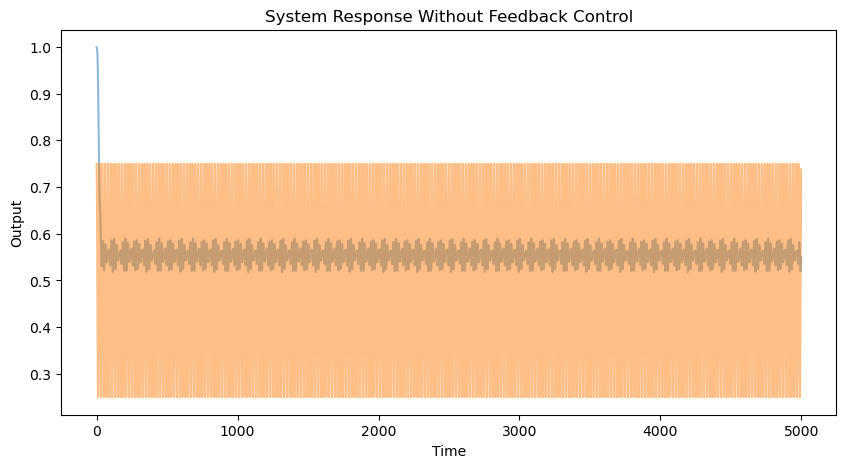

In [27]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
ug = init_state.copy() * 0
us = init_state.copy() * 0
xs_ff_init, outputs_ff_init = [x], []
gainout= 2.5 # 1.15
shiftout= -2.5 # -2.5

for i in time_points[:-1]:

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1,1)

    # update x
    x1 = jnn_ff.f(x, ug, us, r)
    x = x1.copy()
    
    # save
    xs_ff_init.append(x)
    outputs_ff_init.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff_init.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff_init, alpha = 0.5)
plt.plot(time_points, targets, alpha = 0.5)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

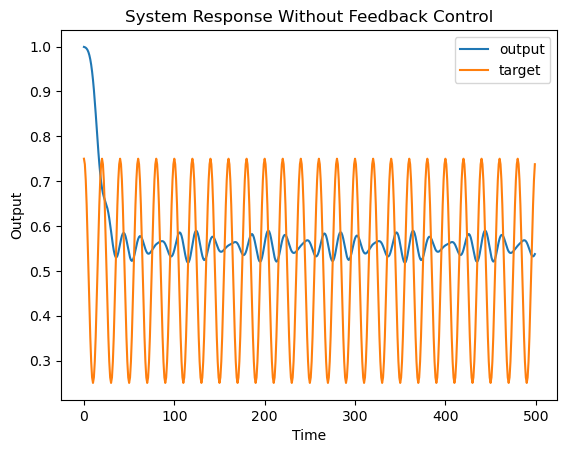

In [21]:
# Plot the output
plt.plot(time_points[0:500], outputs_ff_init[0:500], label='output')
plt.plot(time_points[0:500], targets[0:500], label='target')
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_ff_outputs_0424.png")

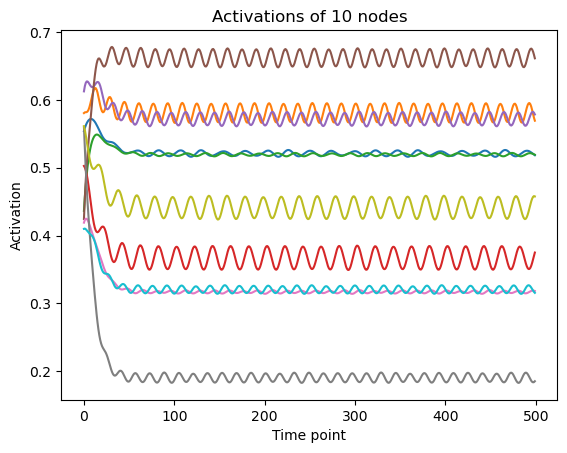

In [22]:
all_xs_ff_init = np.concatenate(xs_ff_init, axis=1)
for i in range(10, 20):
    plt.plot(all_xs_ff_init[i,0:500], label=f"Node {i}")
plt.xlabel("Time point")
plt.ylabel("Activation")
plt.title("Activations of 10 nodes")
if SAVEFIG:
    plt.savefig("fig/FORCE_ff_activations_0424.png")

Definition of phase here: phase = 0 means peak at timepoint 0

Target now has phase = 0

In [23]:
# mean of each node
stable_point = 200
mean_activation = np.mean(all_xs_ff_init[:, stable_point:], axis=1)

In [24]:
periods = []
phases = []
for i in range(num_nodes):
    # for each node, find the time point when it reaches the local maximum
    peak_time = []
    for j in range(stable_point, len(time_points)-1):
        if all_xs_ff_init[i,j-1] < all_xs_ff_init[i,j] and all_xs_ff_init[i,j] > all_xs_ff_init[i,j+1]:
            peak_time.append(j)
    
    peak_time_diff = np.diff(peak_time)
    this_period = np.mean(peak_time_diff).round()
    this_phase = peak_time[0] % this_period

    periods.append(this_period)
    phases.append(this_phase)

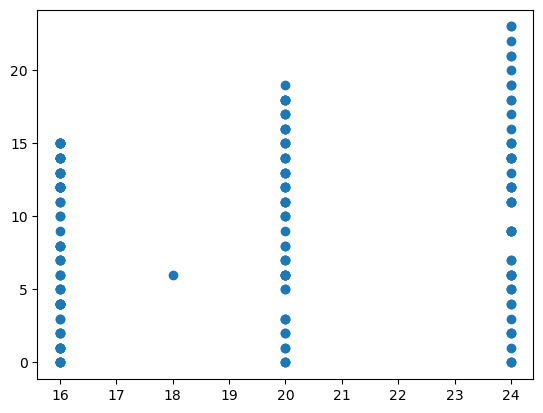

In [25]:
# plot the periods and phases
plt.scatter(periods, phases)

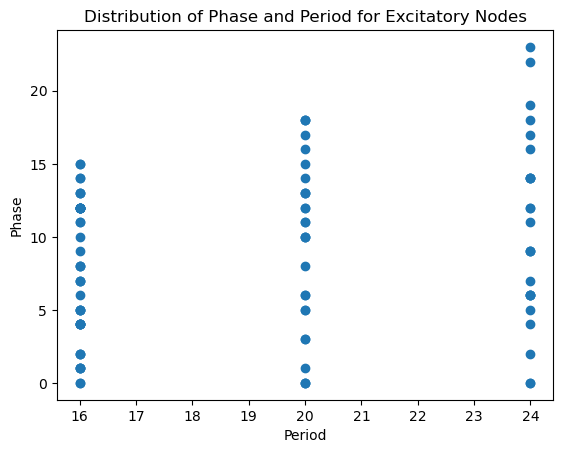

In [26]:
# plot the periods and phases
plt.scatter(np.array(periods)[node_type==1], np.array(phases)[node_type==1])
plt.ylabel("Phase")
plt.xlabel("Period")
plt.title("Distribution of Phase and Period for Excitatory Nodes")
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_phase_period.png")

Text(0, 0.5, 'Output weight')

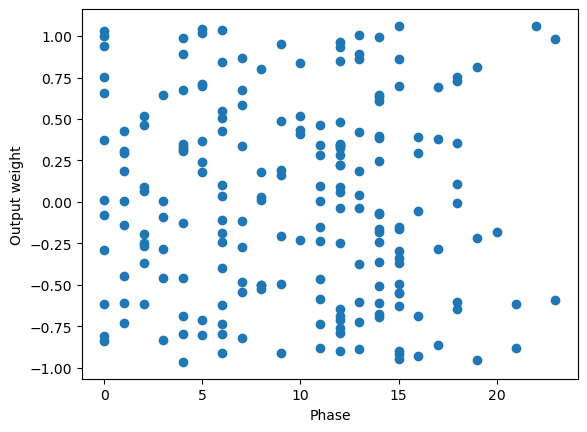

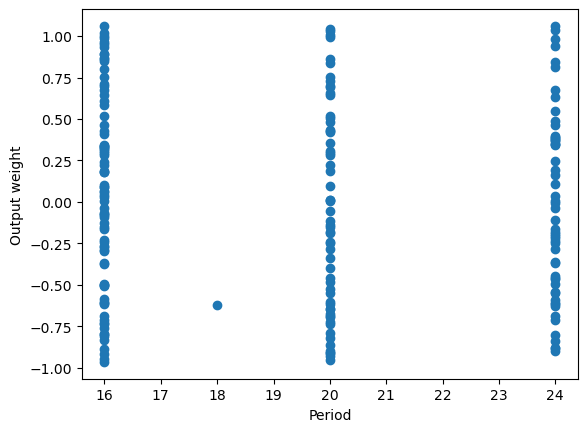

In [151]:
# plot init_output_weight_matrix against phases
plt.subplots()
plt.scatter(phases, init_output_weight_matrix.flatten())
plt.xlabel("Phase")
plt.ylabel("Output weight")

# plot init_output_weight_matrix against periods
plt.subplots()
plt.scatter(periods, init_output_weight_matrix.flatten())
plt.xlabel("Period")
plt.ylabel("Output weight")

### Discrete Tracking Control

In [28]:
# Simulate with control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
ug = init_state.copy() * 0
us = init_state.copy() * 0
xs_fb, ugs_fb, uss_fb, outputs_fb_beforesig, outputs_fb = [x], [], [], [], []

# calculate the desired output before the output sigmoid
gainout= 2.5 # 1.15
shiftout= -2.5 # -2.5
y_tildes = inv_sigmoid_np(targets) / gainout + shiftout

# constants
R = np.eye(2 * num_nodes) * 0.0001  # ug and us
Q1 = np.eye(num_nodes) * 0.001
Q2 = np.eye(1) * 10

for t in tqdm(time_points[:1000]):

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # input
    this_input = inputs[:,t]
    r = feedback_weight_matrix * this_input.reshape(-1,1)
    
    # linear approxmation of nonlinear system
    # linear approximate F and G
    F, Gg, Gs, _ = jnn.jacob(x, ug, us, r)   # x_t, u_t-1
    c = jnn.f(x, ug, us, r) - F @ x - Gg @ ug - Gs @ us # the constant term after approximation
    # augment the system for the constant term
    F_aug = np.concatenate([np.concatenate([F, np.eye(num_nodes)], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    G = np.concatenate([Gg, Gs], axis=1)  # num_nodes x 2*num_nodes
    G_aug = np.concatenate([G, np.zeros((num_nodes, 2 * num_nodes))], axis=0)
    x_aug = np.concatenate([x, c], axis=0)

    # get H
    H = output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    y_tilde = y_tildes[t+1]
    x_tilde = L @ np.array([[y_tilde]])
    x_tilde_aug = np.concatenate([x_tilde, c], axis=0)
    # Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.zeros((num_nodes, num_nodes))], axis=1)], axis=0)

    # get the control input u
    # backward solve
    S_t2 = Q_aug
    b_t2 = np.zeros(shape=(2 * num_nodes, 1))
    S_t1 = F_aug.T @ (S_t2 - S_t2 @ G_aug @ np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2) @ F_aug + Q_aug
    K_T_t1 = -np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2 @ F_aug
    b_t1 = (F_aug.T + K_T_t1.T @ G_aug.T) @ b_t2 - Q_aug @ x_tilde_aug
    # calculate u_t
    u1 = -np.linalg.inv(G_aug.T @ S_t1 @ G_aug + R) @ G_aug.T @ (S_t1 @ F_aug @ x_aug + b_t1)
    # u = np.linalg.pinv(G) @ (G @ u1 - B @ r)
    # update u
    u = u1.copy()
    
    # update x
    ug = u[0:num_nodes]
    us = u[num_nodes:]
    x1 = jnn.f(x, ug, us, r)
    x = x1.copy()
    
    # save
    xs_fb.append(x)
    ugs_fb.append(ug)
    uss_fb.append(us)
    outputs_fb_beforesig.append(output_beforesig.item())
    outputs_fb.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_fb_beforesig.append(output_beforesig.item())
outputs_fb.append(output.item())

  0%|          | 0/1000 [00:00<?, ?it/s]

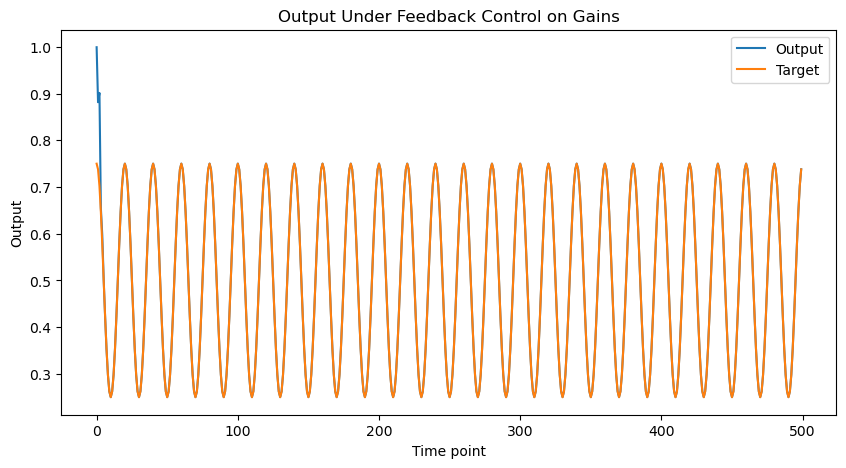

In [30]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[0:500], outputs_fb[0:500], label='Output')
plt.plot(time_points[0:500],targets[0:500], label='Target')
plt.title('Output Under Feedback Control on Gains')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_tracking_output_0424.png")

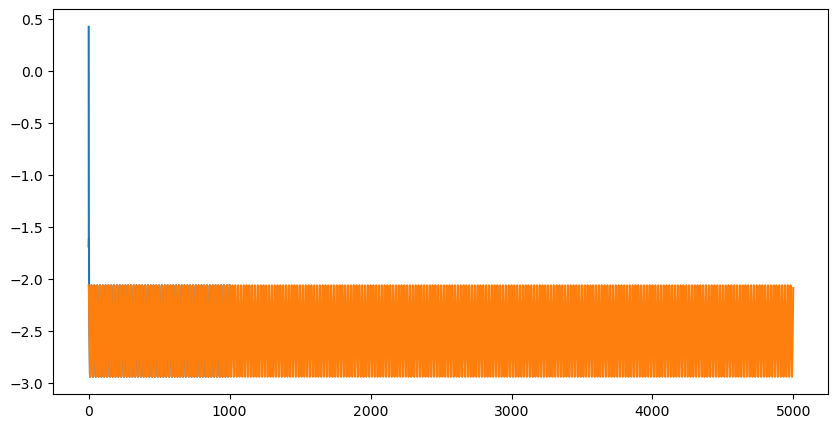

In [31]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(outputs_fb_beforesig)
plt.plot(y_tildes)

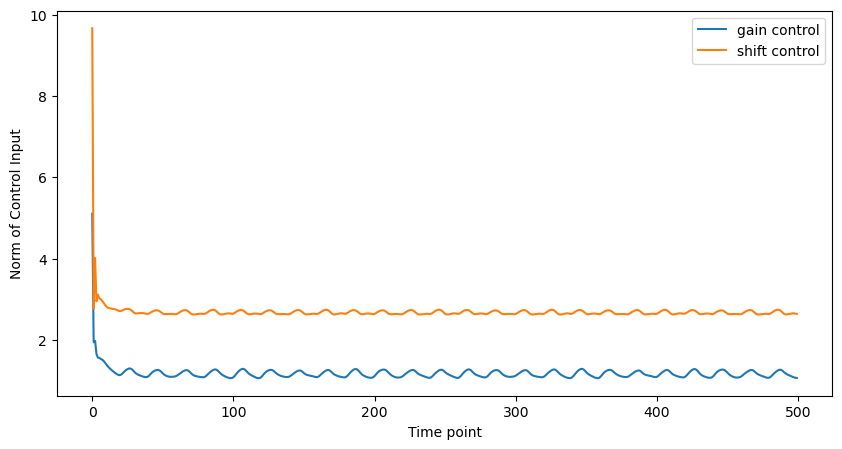

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))
ugs_norm = [np.linalg.norm(u) for u in ugs_fb]
uss_norm = [np.linalg.norm(u) for u in uss_fb]

plt.plot(ugs_norm[0:500], label='gain control')
plt.plot(uss_norm[0:500], label = 'shift control')
plt.ylabel('Norm of Control Input')
plt.xlabel('Time point')
plt.legend()
if SAVEFIG:
    plt.savefig("fig/FORCE_tracking_unorm_0424.png")

### FB Control + Hebbian Learning

In [45]:
# Simulate with control + Hebb + adjout
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
ug = init_state.copy() * 0
us = init_state.copy() * 0
this_output_weight_matrix = output_weight_matrix.copy()
xs_hebb, ugs_hebb, uss_hebb, outputs_hebb_beforesig, outputs_hebb = [x], [], [], [], []
has_hebbian = False

# constants
R = np.eye(2 * num_nodes) * 0.0001
Q1 = np.eye(num_nodes) * 0.001
Q2 = np.eye(1) * 10
hebbian_lr = 0.01
neg_punishment = 1.5
gainout= 2.5 # 1.15
shiftout= -2.5 # -2.5
period = 2 * half_period

for t in tqdm(time_points[:-1]):

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # update readout weights by hebbian learning
    if not has_hebbian and t > 100:
        has_hebbian = True
        x_mean = np.concatenate(xs_hebb, axis=1).mean(axis=1).reshape(-1, 1)
        x_std = np.concatenate(xs_hebb, axis=1).std(axis=1).reshape(-1, 1)
        # output_mean = np.array(outputs_fb).mean()
        output_mean = 0.5
    if has_hebbian:
        # Calculate Hebbian weight updates
        hebbian_update = (output - output_mean) * ((x - x_mean) / x_std).T
        hebbian_update[np.logical_and(hebbian_update < 0, node_type == 1)] *= neg_punishment  # exh, punish <0
        hebbian_update[np.logical_and(hebbian_update > 0, node_type == -1)] *= neg_punishment  # inh, punish >0
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext[tmp_ext < 0] = 0
        tmp_inh[tmp_inh > 0] = 0
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        this_output_weight_matrix = tmp_output_weight_matrix.copy()

    # input
    this_input = inputs[:,t]
    r = feedback_weight_matrix * this_input.reshape(-1,1)

    # linear approxmation of nonlinear system
    # linear approximate F and G
    F, Gg, Gs, _ = jnn.jacob(x, ug, us, r)   # x_t, u_t-1
    c = jnn.f(x, ug, us, r) - F @ x - Gg @ ug - Gs @ us # the constant term after approximation
    # augment the system for the constant term
    F_aug = np.concatenate([np.concatenate([F, np.eye(num_nodes)], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    G = np.concatenate([Gg, Gs], axis=1)  # num_nodes x 2*num_nodes
    G_aug = np.concatenate([G, np.zeros((num_nodes, 2 * num_nodes))], axis=0)
    x_aug = np.concatenate([x, c], axis=0)

    # get H
    H = this_output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    # y_tilde = y_tildes[t+1]
    y_tilde = inv_sigmoid_np(targets[t+1]) / gainout + shiftout
    x_tilde = L @ np.array([[y_tilde]])
    x_tilde_aug = np.concatenate([x_tilde, c], axis=0)
    # Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.zeros((num_nodes, num_nodes))], axis=1)], axis=0)

    # get the control input u
    # backward solve
    S_t2 = Q_aug
    b_t2 = np.zeros(shape=(2 * num_nodes, 1))
    S_t1 = F_aug.T @ (S_t2 - S_t2 @ G_aug @ np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2) @ F_aug + Q_aug
    K_T_t1 = -np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2 @ F_aug
    b_t1 = (F_aug.T + K_T_t1.T @ G_aug.T) @ b_t2 - Q_aug @ x_tilde_aug
    # calculate u_t
    u1 = -np.linalg.inv(G_aug.T @ S_t1 @ G_aug + R) @ G_aug.T @ (S_t1 @ F_aug @ x_aug + b_t1)
    # update u
    u = u1.copy()
    
    # update x
    ug = u[0:num_nodes]
    us = u[num_nodes:]
    x1 = jnn.f(x, ug, us, r)
    x = x1.copy()
   
    # save
    xs_hebb.append(x)
    ugs_hebb.append(ug)
    uss_hebb.append(us)
    outputs_hebb_beforesig.append(output_beforesig.item())
    outputs_hebb.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_hebb_beforesig.append(output_beforesig.item())
outputs_hebb.append(output.item())

  0%|          | 0/4999 [00:00<?, ?it/s]

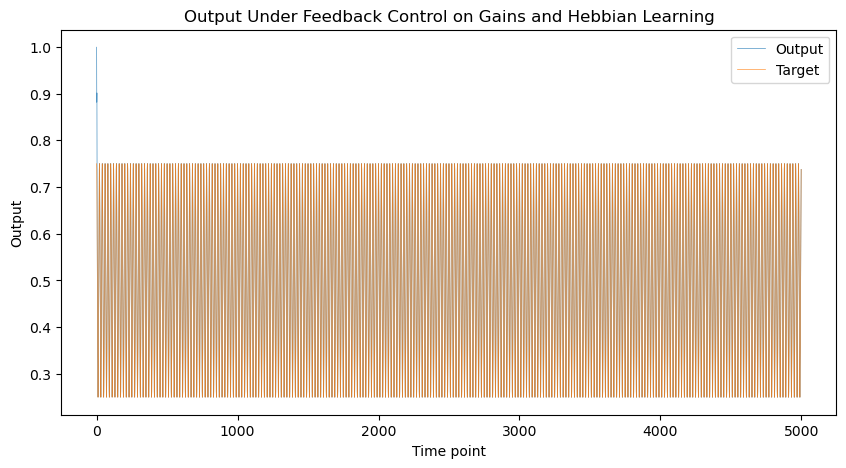

In [61]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_hebb, label='Output', alpha=0.8, lw=0.5)
plt.plot(time_points, targets, label='Target', alpha=0.8, lw=0.5)
plt.title('Output Under Feedback Control on Gains and Hebbian Learning')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_FBhebb_output.png")

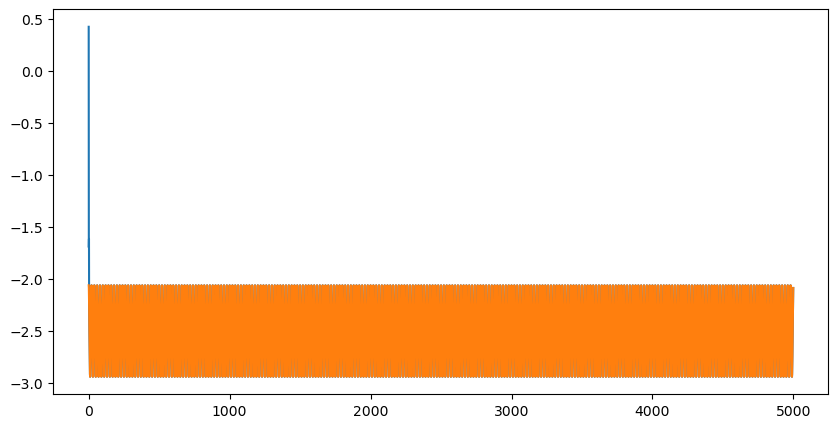

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(outputs_hebb_beforesig)
plt.plot(y_tildes)

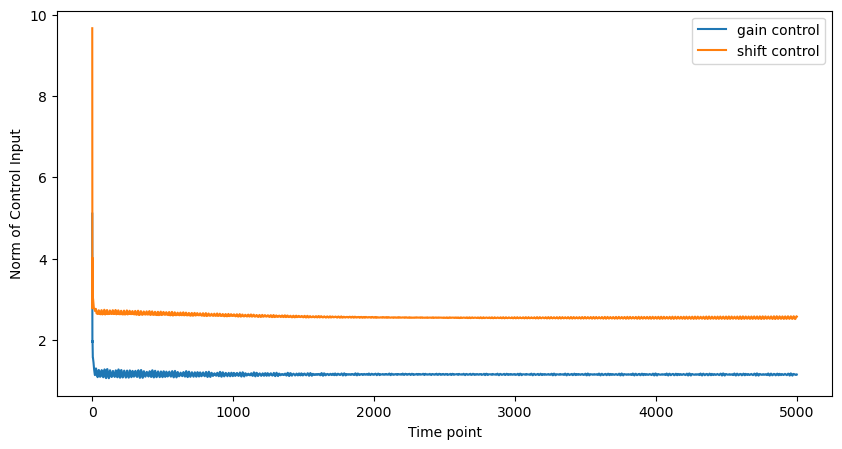

In [62]:
fig, ax = plt.subplots(figsize=(10, 5))
ugs_norm = [np.linalg.norm(u) for u in ugs_hebb]
uss_norm = [np.linalg.norm(u) for u in uss_hebb]

plt.plot(ugs_norm, label='gain control')
plt.plot(uss_norm, label = 'shift control')
plt.ylabel('Norm of Control Input')
plt.xlabel('Time point')
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_FBhebb_unorm.png")

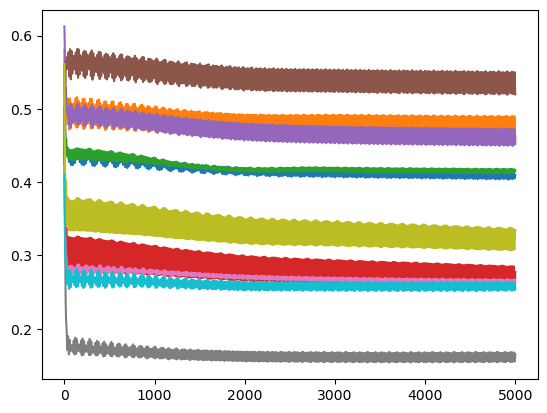

In [49]:
all_xs_hebb = np.concatenate(xs_hebb, axis=1)
for i in range(10, 20):
    plt.plot(all_xs_hebb[i,:], label=f"Node {i}")

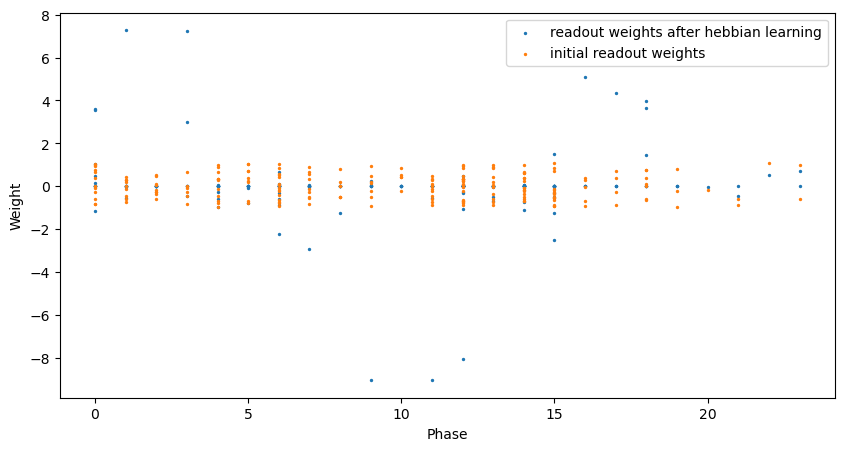

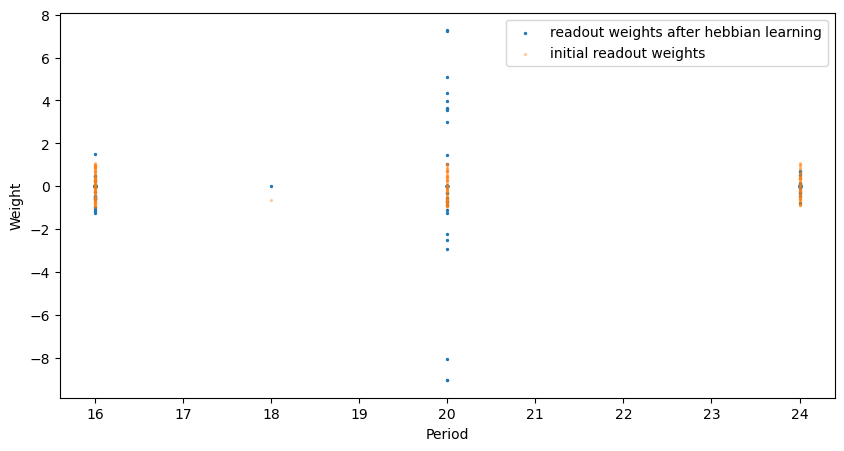

In [63]:
plt.subplots(figsize=(10, 5))
plt.scatter(phases, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(phases, init_output_weight_matrix.flatten(), s=2, label="initial readout weights")
plt.xlabel("Phase")
plt.ylabel("Weight")
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_FBhebb_weights_phase_neg{neg_punishment}.png")

plt.subplots(figsize=(10, 5))
plt.scatter(periods, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(periods, init_output_weight_matrix.flatten(), s=2, label="initial readout weights", alpha=0.3)
plt.xlabel("Period")
plt.ylabel("Weight")
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_FBhebb_weights_period_neg{neg_punishment}.png")

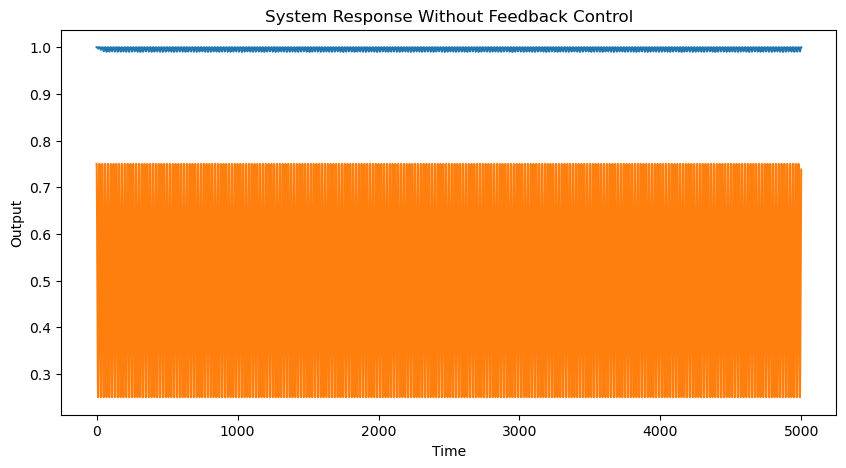

In [65]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
ug = init_state.copy() * 0
us = init_state.copy() * 0
xs_ff_after, outputs_ff_after = [x], []
gainout = 2.5 # 1
shiftout = -2.5 # -1.6

for i in time_points[:-1]:

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1, 1)
    
    # update x
    x1 = jnn_ff.f(x, ug, us, r)
    x = x1.copy()

    # save
    xs_ff_after.append(x)
    outputs_ff_after.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff_after.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff_after)
plt.plot(time_points, targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

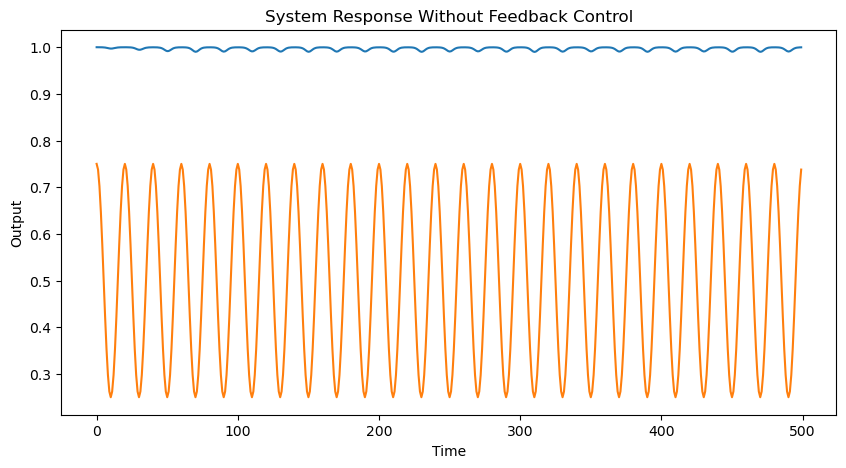

In [66]:
# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[0:500], outputs_ff_after[0:500])
plt.plot(time_points[0:500], targets[0:500])
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_FBhebb_outputs_after.png")

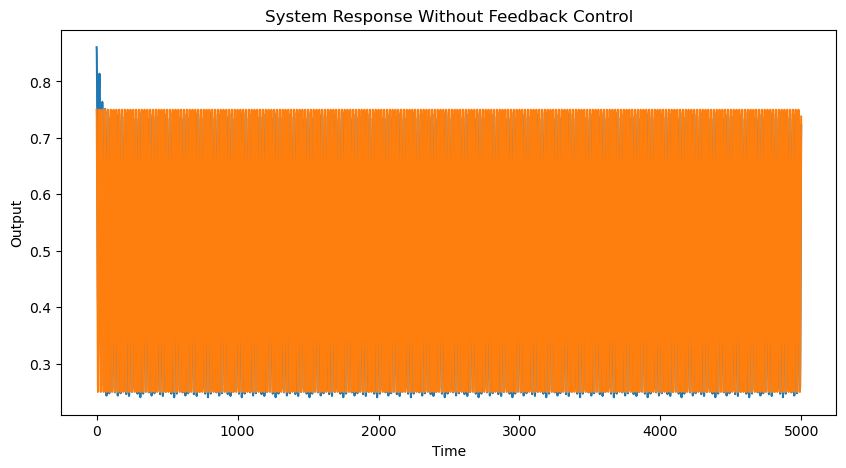

In [67]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
ug = init_state.copy() * 0
us = init_state.copy() * 0
xs_ff_after, outputs_ff_after = [x], []
gainout = 1.5 # 1
shiftout = 0.1 # -1.6

for i in time_points[:-1]:

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1, 1)
    
    # update x
    x1 = jnn_ff.f(x, ug, us, r)
    x = x1.copy()

    # save
    xs_ff_after.append(x)
    outputs_ff_after.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff_after.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff_after)
plt.plot(time_points, targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

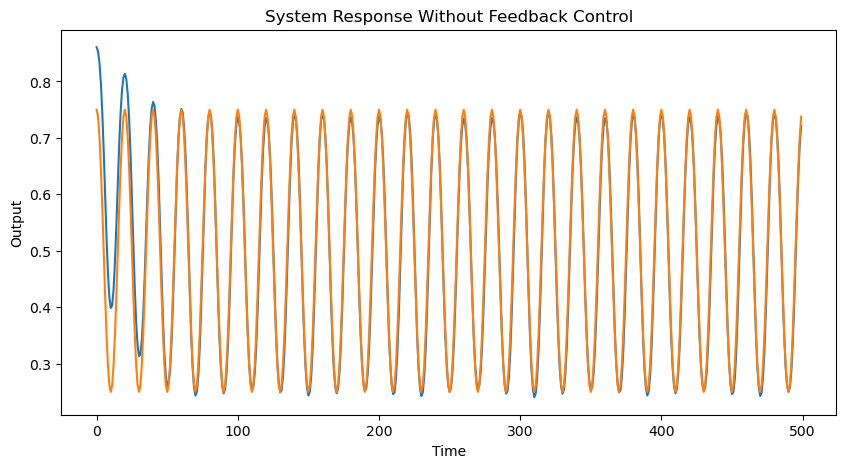

In [68]:
# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[0:500], outputs_ff_after[0:500])
plt.plot(time_points[0:500], targets[0:500])
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_FBhebb_outputs_after_adjout.png")

### FB Control + Hebbian Learning (Only EXH)

In [115]:
# Simulate with control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
ug = init_state.copy() * 0
us = init_state.copy() * 0
this_output_weight_matrix = output_weight_matrix.copy()
xs_hebb, ugs_hebb, uss_hebb, outputs_hebb_beforesig, outputs_hebb = [x], [], [], [], []
has_hebbian = False

# constants
R = np.eye(2 * num_nodes) * 0.0001
Q1 = np.eye(num_nodes) * 0.001
Q2 = np.eye(1) * 10
hebbian_lr = 0.01
neg_punishment = 1.5
gainout= 2.5 # 1.15
shiftout= -2.5 # -2.5
period = 2 * half_period

for t in tqdm(time_points[:-1]):

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # update readout weights by hebbian learning
    if not has_hebbian and t > 1000:
        has_hebbian = True
        x_mean = np.concatenate(xs_hebb, axis=1).mean(axis=1).reshape(-1, 1)
        x_std = np.concatenate(xs_hebb, axis=1).std(axis=1).reshape(-1, 1)
        # output_mean = np.array(outputs_fb).mean()
        output_mean = 0.5
    if has_hebbian:
        # Calculate Hebbian weight updates
        hebbian_update = (output - output_mean) * ((x - x_mean) / x_std).T
        hebbian_update[np.logical_and(hebbian_update < 0, node_type == 1)] *= neg_punishment  # exh, punish <0
        hebbian_update[: ,node_type == -1] *= 0  # inh
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_ext[tmp_ext < 0] = 0
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        # update init weights
        this_output_weight_matrix = tmp_output_weight_matrix.copy()

    # input
    this_input = inputs[:,t]
    r = feedback_weight_matrix * this_input.reshape(-1,1)

    # linear approxmation of nonlinear system
    # linear approximate F and G
    F, Gg, Gs, _ = jnn.jacob(x, ug, us, r)   # x_t, u_t-1
    c = jnn.f(x, ug, us, r) - F @ x - Gg @ ug - Gs @ us # the constant term after approximation
    # augment the system for the constant term
    F_aug = np.concatenate([np.concatenate([F, np.eye(num_nodes)], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    G = np.concatenate([Gg, Gs], axis=1)  # num_nodes x 2*num_nodes
    G_aug = np.concatenate([G, np.zeros((num_nodes, 2 * num_nodes))], axis=0)
    x_aug = np.concatenate([x, c], axis=0)

    # get H
    H = this_output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    y_tilde = inv_sigmoid_np(targets[t+1]) / gainout + shiftout
    x_tilde = L @ np.array([[y_tilde]])
    x_tilde_aug = np.concatenate([x_tilde, c], axis=0)
    # Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.zeros((num_nodes, num_nodes))], axis=1)], axis=0)

    # get the control input u
    # backward solve
    S_t2 = Q_aug
    b_t2 = np.zeros(shape=(2 * num_nodes, 1))
    S_t1 = F_aug.T @ (S_t2 - S_t2 @ G_aug @ np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2) @ F_aug + Q_aug
    K_T_t1 = -np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2 @ F_aug
    b_t1 = (F_aug.T + K_T_t1.T @ G_aug.T) @ b_t2 - Q_aug @ x_tilde_aug
    # calculate u_t
    u1 = -np.linalg.inv(G_aug.T @ S_t1 @ G_aug + R) @ G_aug.T @ (S_t1 @ F_aug @ x_aug + b_t1)
    # update u
    u = u1.copy()
    
    # update x
    ug = u[0:num_nodes]
    us = u[num_nodes:]
    x1 = jnn.f(x, ug, us, r)
    x = x1.copy()
   
    # save
    xs_hebb.append(x)
    ugs_hebb.append(ug)
    uss_hebb.append(us)
    outputs_hebb_beforesig.append(output_beforesig.item())
    outputs_hebb.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_hebb_beforesig.append(output_beforesig.item())
outputs_hebb.append(output.item())

  0%|          | 0/4999 [00:00<?, ?it/s]

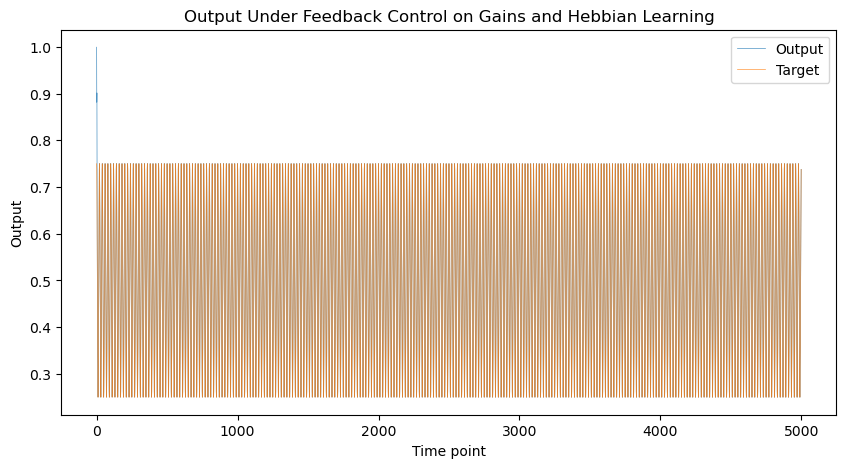

In [116]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_hebb, label='Output', alpha=0.8, lw=0.5)
plt.plot(time_points, targets, label='Target', alpha=0.8, lw=0.5)
plt.title('Output Under Feedback Control on Gains and Hebbian Learning')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_Ext_output.png")

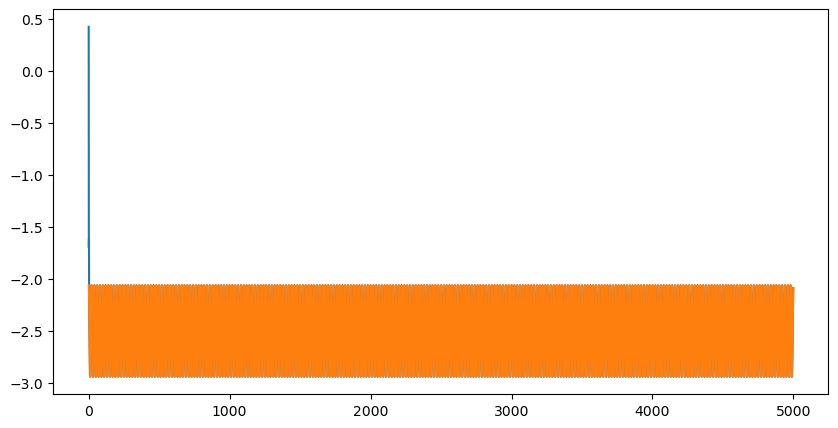

In [117]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(outputs_hebb_beforesig)
plt.plot(y_tildes)

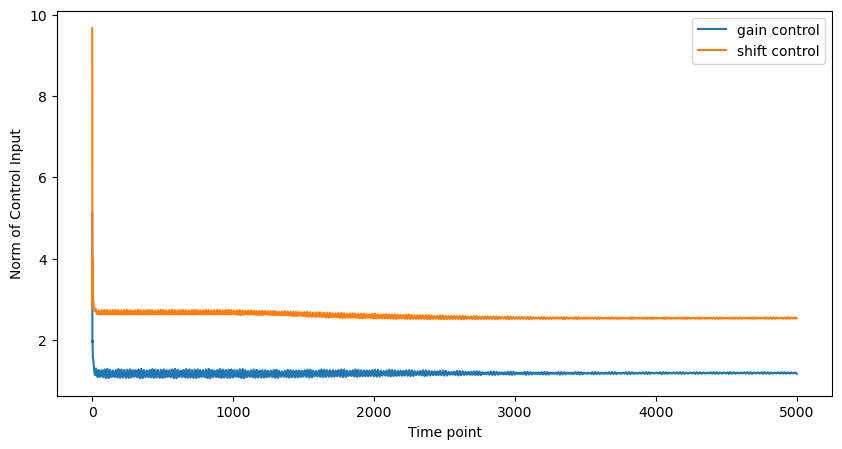

In [118]:
fig, ax = plt.subplots(figsize=(10, 5))
ugs_norm = [np.linalg.norm(u) for u in ugs_hebb]
uss_norm = [np.linalg.norm(u) for u in uss_hebb]

plt.plot(ugs_norm, label='gain control')
plt.plot(uss_norm, label = 'shift control')
plt.ylabel('Norm of Control Input')
plt.xlabel('Time point')
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_Ext_unorm.png")

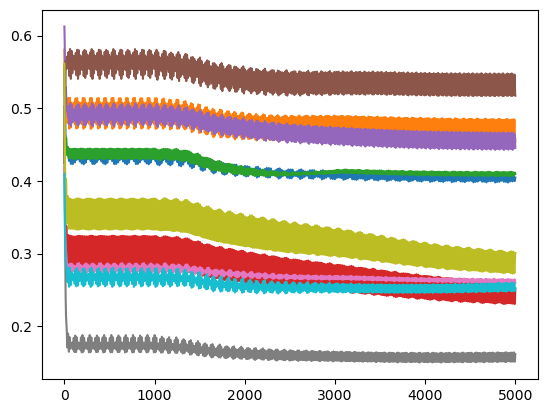

In [119]:
all_xs_hebb = np.concatenate(xs_hebb, axis=1)
for i in range(10, 20):
    plt.plot(all_xs_hebb[i,:], label=f"Node {i}")

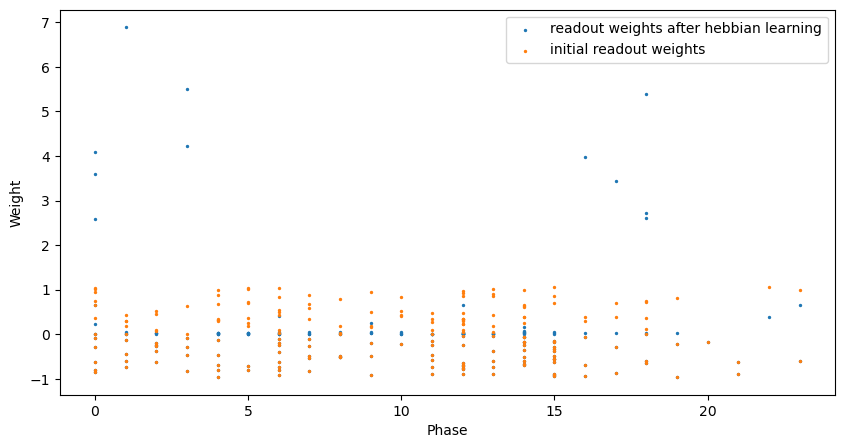

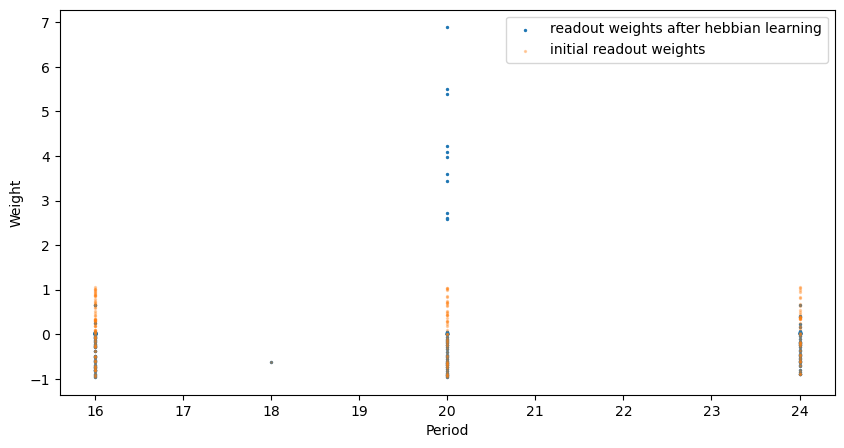

In [120]:
plt.subplots(figsize=(10, 5))
plt.scatter(phases, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(phases, init_output_weight_matrix.flatten(), s=2, label="initial readout weights")
plt.xlabel("Phase")
plt.ylabel("Weight")
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_Ext_weights_phase.png")

plt.subplots(figsize=(10, 5))
plt.scatter(periods, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(periods, init_output_weight_matrix.flatten(), s=2, label="initial readout weights", alpha=0.3)
plt.xlabel("Period")
plt.ylabel("Weight")
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_Ext_weights_period.png")

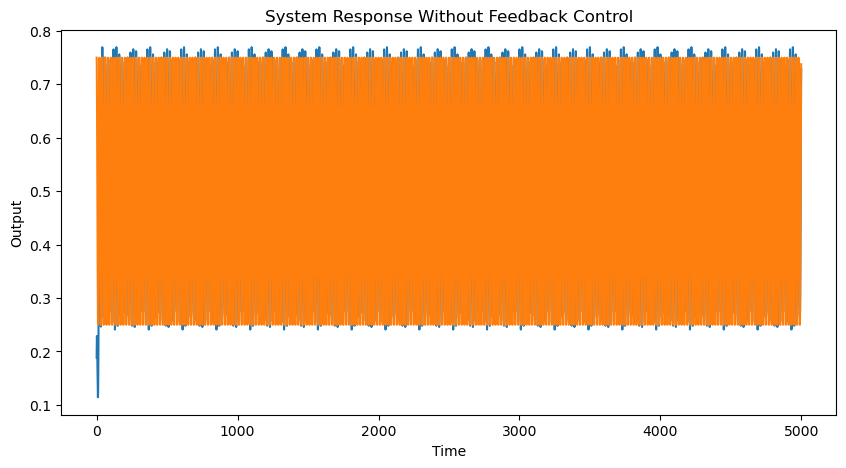

In [121]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
ug = init_state.copy() * 0
us = init_state.copy() * 0
xs_ff_after, outputs_ff_after = [x], []
gainout = 2.5 # 1
shiftout = 0.15 # -1.6

for i in time_points[:-1]:

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1, 1)
    
    # update x
    x1 = jnn_ff.f(x, ug, us, r)
    x = x1.copy()

    # save
    xs_ff_after.append(x)
    outputs_ff_after.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff_after.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff_after)
plt.plot(time_points, targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

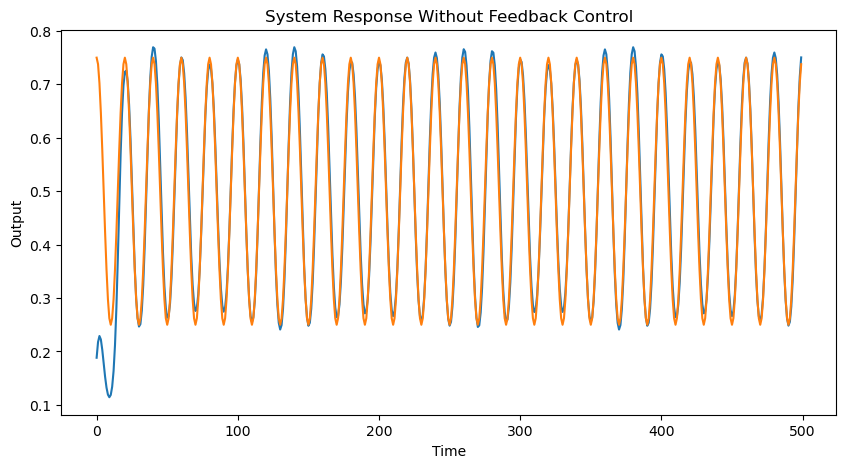

In [122]:
# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[0:500], outputs_ff_after[0:500])
plt.plot(time_points[0:500], targets[0:500])
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_Ext_output_after_adjout.png")

### FB Control + Hebbian Learning (Only EXH + Kris's Rule)

In [97]:
# Simulate with control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
ug = init_state.copy() * 0
us = init_state.copy() * 0
this_output_weight_matrix = output_weight_matrix.copy()
xs_hebb, ugs_hebb, uss_hebb, outputs_hebb_beforesig, outputs_hebb = [x], [], [], [], []
has_hebbian = False

# constants
R = np.eye(2 * num_nodes) * 0.0001
Q1 = np.eye(num_nodes) * 0.001
Q2 = np.eye(1) * 10
pos_hebbian_lr = 0.05
neg_hebbian_lr = 0.05
beta = 0.5
gainout= 2.5 # 1.15
shiftout= -2.5 # -2.5
period = 2 * half_period

for t in tqdm(time_points[:-1]):

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # update readout weights by hebbian learning
    if not has_hebbian and t > 1000:
        has_hebbian = True
        x_mean = np.concatenate(xs_hebb, axis=1).mean(axis=1).reshape(-1, 1)
        x_std = np.concatenate(xs_hebb, axis=1).std(axis=1).reshape(-1, 1)
        # output_mean = np.array(outputs_fb).mean()
        output_mean = 0.5
    if has_hebbian:
        # Calculate Hebbian weight updates, only for ext nodes
        hebbian_update = ((output - output_mean) * ((x - x_mean) / x_std).T)[:, node_type == 1]
        ext_output_weight_matrix = this_output_weight_matrix[:, node_type == 1]
        f_plus = np.power(1 - ext_output_weight_matrix/ext_weight_sum, beta)
        f_minus = np.power(ext_output_weight_matrix/ext_weight_sum, beta)
        plus_index = hebbian_update > 0
        minus_index = hebbian_update < 0
        pos_hebbian_lr = 0 if output < output_mean else 0.05  # no LTP when output and x both below mean
        hebbian_update[plus_index] *= pos_hebbian_lr * f_plus[plus_index]
        hebbian_update[minus_index] *= neg_hebbian_lr * f_minus[minus_index]
        # Normalized Hebbian learning
        ext_output_weight_matrix = ext_output_weight_matrix + hebbian_update
        ext_output_weight_matrix[ext_output_weight_matrix < 0] = 0
        ext_output_weight_matrix /= np.sum(np.abs(ext_output_weight_matrix)) / ext_weight_sum
        # update init weights
        this_output_weight_matrix[:, node_type == 1] = ext_output_weight_matrix

    # input
    this_input = inputs[:,t]
    r = feedback_weight_matrix * this_input.reshape(-1,1)

    # linear approxmation of nonlinear system
    # linear approximate F and G
    F, Gg, Gs, _ = jnn.jacob(x, ug, us, r)   # x_t, u_t-1
    c = jnn.f(x, ug, us, r) - F @ x - Gg @ ug - Gs @ us # the constant term after approximation
    # augment the system for the constant term
    F_aug = np.concatenate([np.concatenate([F, np.eye(num_nodes)], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    G = np.concatenate([Gg, Gs], axis=1)  # num_nodes x 2*num_nodes
    G_aug = np.concatenate([G, np.zeros((num_nodes, 2 * num_nodes))], axis=0)
    x_aug = np.concatenate([x, c], axis=0)

    # get H
    H = this_output_weight_matrix.T
    L = H @ np.linalg.inv(H.T @ H)
    H_bar = (np.eye(num_nodes) - L @ H.T).T
    Q = H_bar @ Q1 @ H_bar.T + H @ Q2 @ H.T
    y_tilde = inv_sigmoid_np(targets[t+1]) / gainout + shiftout
    x_tilde = L @ np.array([[y_tilde]])
    x_tilde_aug = np.concatenate([x_tilde, c], axis=0)
    # Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.eye(num_nodes)], axis=1)], axis=0)
    Q_aug = np.concatenate([np.concatenate([Q, np.zeros((num_nodes, num_nodes))], axis=1), np.concatenate([np.zeros((num_nodes, num_nodes)), np.zeros((num_nodes, num_nodes))], axis=1)], axis=0)

    # get the control input u
    # backward solve
    S_t2 = Q_aug
    b_t2 = np.zeros(shape=(2 * num_nodes, 1))
    S_t1 = F_aug.T @ (S_t2 - S_t2 @ G_aug @ np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2) @ F_aug + Q_aug
    K_T_t1 = -np.linalg.inv(G_aug.T @ S_t2 @ G_aug + R) @ G_aug.T @ S_t2 @ F_aug
    b_t1 = (F_aug.T + K_T_t1.T @ G_aug.T) @ b_t2 - Q_aug @ x_tilde_aug
    # calculate u_t
    u1 = -np.linalg.inv(G_aug.T @ S_t1 @ G_aug + R) @ G_aug.T @ (S_t1 @ F_aug @ x_aug + b_t1)
    # update u
    u = u1.copy()
    
    # update x
    ug = u[0:num_nodes]
    us = u[num_nodes:]
    x1 = jnn.f(x, ug, us, r)
    x = x1.copy()
   
    # save
    xs_hebb.append(x)
    ugs_hebb.append(ug)
    uss_hebb.append(us)
    outputs_hebb_beforesig.append(output_beforesig.item())
    outputs_hebb.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_hebb_beforesig.append(output_beforesig.item())
outputs_hebb.append(output.item())

  0%|          | 0/4999 [00:00<?, ?it/s]

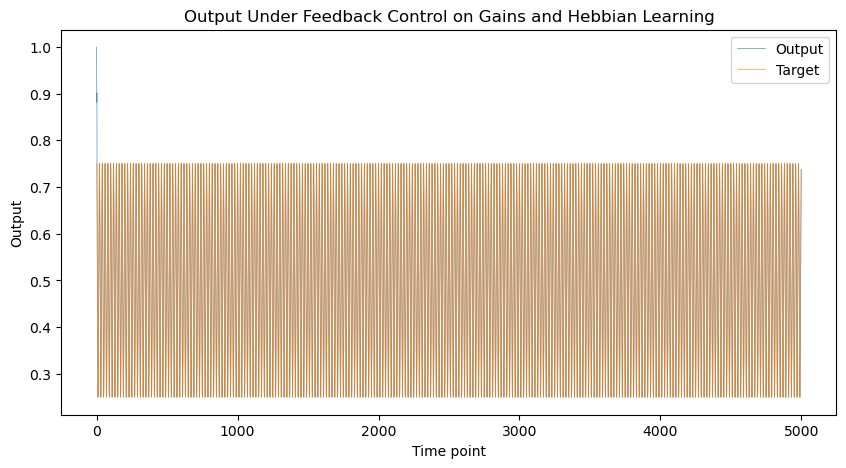

In [105]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_hebb, label='Output', alpha=0.8, lw=0.5)
plt.plot(time_points, targets, label='Target', alpha=0.8, lw=0.5)
plt.title('Output Under Feedback Control on Gains and Hebbian Learning')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_Kris_output.png")

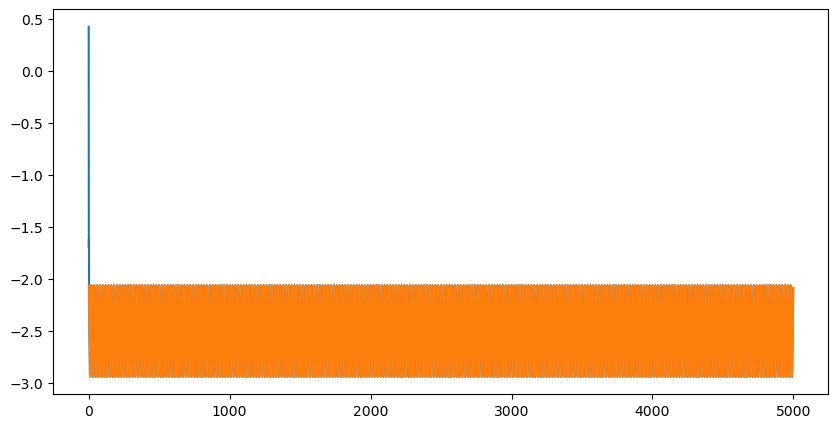

In [99]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(outputs_hebb_beforesig)
plt.plot(y_tildes)

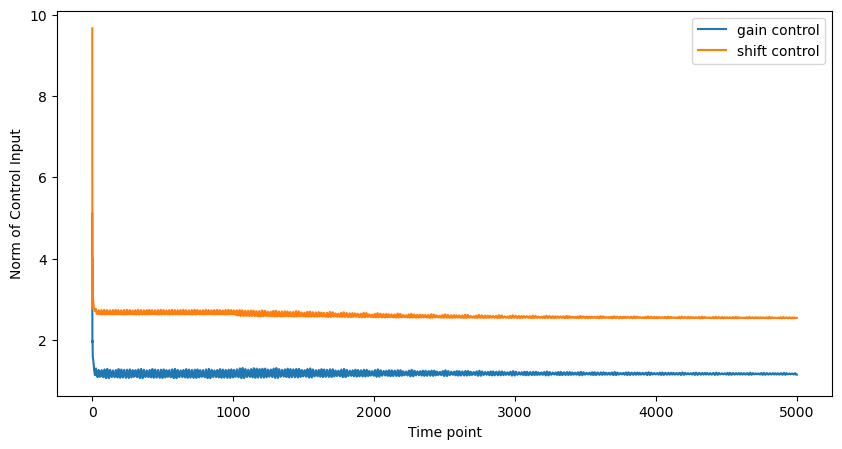

In [106]:
fig, ax = plt.subplots(figsize=(10, 5))
ugs_norm = [np.linalg.norm(u) for u in ugs_hebb]
uss_norm = [np.linalg.norm(u) for u in uss_hebb]

plt.plot(ugs_norm, label='gain control')
plt.plot(uss_norm, label = 'shift control')
plt.ylabel('Norm of Control Input')
plt.xlabel('Time point')
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_Kris_unorm.png")

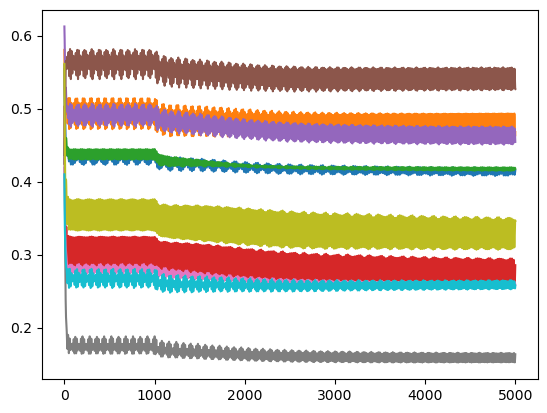

In [101]:
all_xs_hebb = np.concatenate(xs_hebb, axis=1)
for i in range(10, 20):
    plt.plot(all_xs_hebb[i,:], label=f"Node {i}")

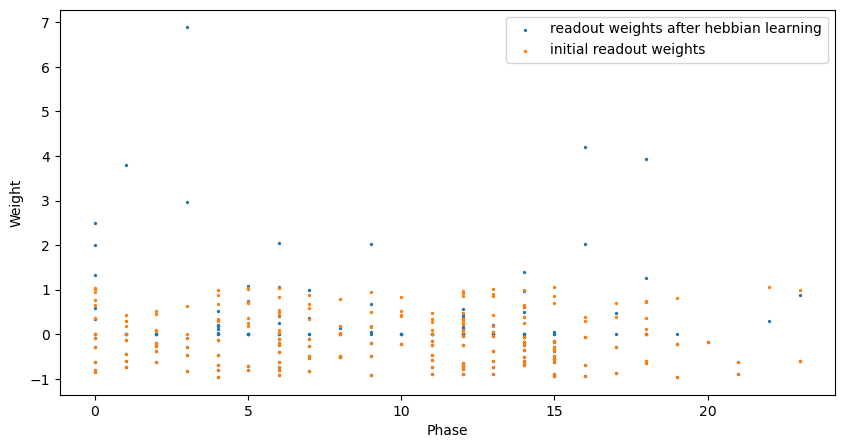

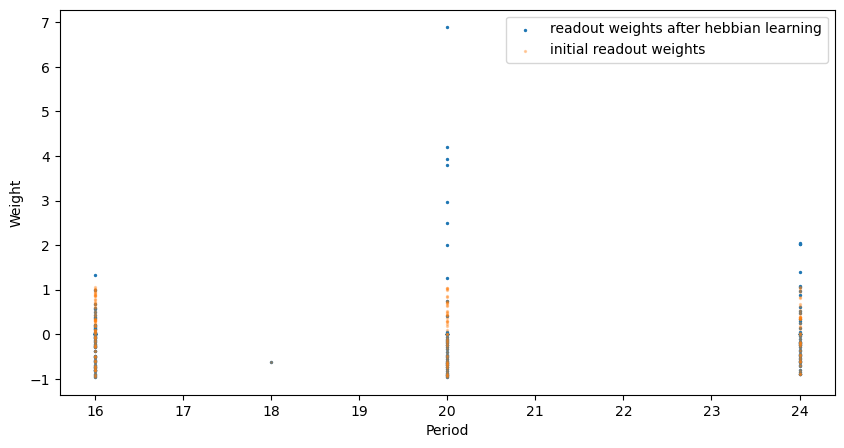

In [107]:
plt.subplots(figsize=(10, 5))
plt.scatter(phases, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(phases, init_output_weight_matrix.flatten(), s=2, label="initial readout weights")
plt.xlabel("Phase")
plt.ylabel("Weight")
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_Kris_weights_phase.png")

plt.subplots(figsize=(10, 5))
plt.scatter(periods, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(periods, init_output_weight_matrix.flatten(), s=2, label="initial readout weights", alpha=0.3)
plt.xlabel("Period")
plt.ylabel("Weight")
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_Kris_weights_period.png")

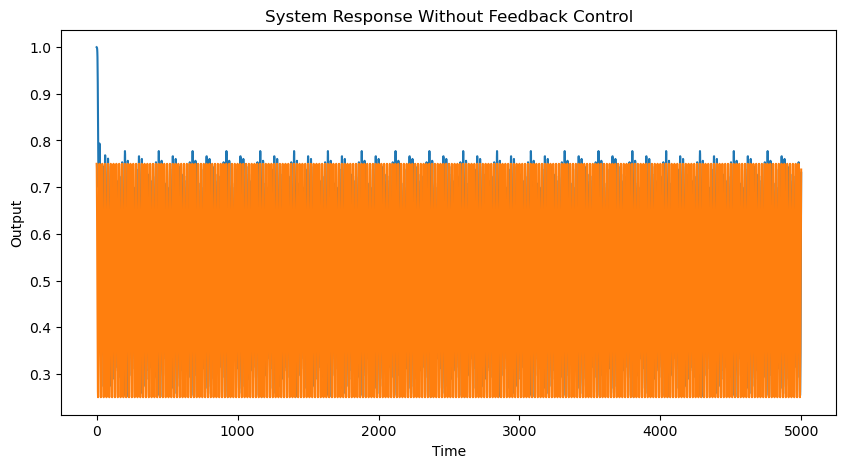

In [113]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
ug = init_state.copy() * 0
us = init_state.copy() * 0
xs_ff_after, outputs_ff_after = [x], []
gainout = 3.2 # 1
shiftout = -1.8 # -1.6

for i in time_points[:-1]:

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1, 1)
    
    # update x
    x1 = jnn_ff.f(x, ug, us, r)
    x = x1.copy()

    # save
    xs_ff_after.append(x)
    outputs_ff_after.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff_after.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff_after)
plt.plot(time_points, targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

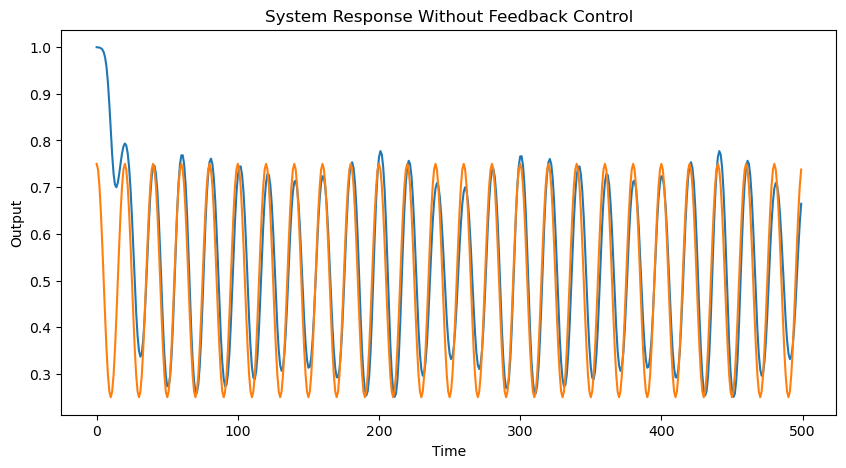

In [114]:
# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[0:500], outputs_ff_after[0:500])
plt.plot(time_points[0:500], targets[0:500])
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
if SAVEFIG:
    plt.savefig(f"fig/{date}_{filename}_Kris_output_after_adjout.png")